In [1]:
import numpy as np
import time
import matplotlib
from qiskit import IBMQ

# Import Qiskit classes
import qiskit 
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, Aer
from qiskit.providers.aer import noise
from qiskit.tools.visualization import plot_histogram

# Import measurement calibration functions
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)

In [2]:
# Load account from disk
provider = IBMQ.load_account()
# List the account currently in the session
print(IBMQ.active_account())
# List all available providers
print(IBMQ.providers())
# List all available providers 
print(provider.backends())

{'token': 'a68ed5f01ae762a863d05960b20488a24b834174d145ba4bea63975b06d4bd534f10e0659a8ec4f79c23ff61daa64294b82d531d6cf08fcdcdba7661371f9a09', 'url': 'https://auth.quantum-computing.ibm.com/api'}
[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>, <AccountProvider for IBMQ(hub='ibm-q-hub-ntu', group='ntu-internal', project='default')>]
[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmqx4') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>]


# 1. Error mitigation of Bell state on real devices
$$ \mid \phi^+ \rangle = \frac{\mid{00} \rangle + \mid{11} \rangle}{\sqrt{2}}$$

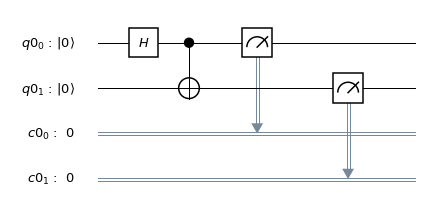

In [3]:
# Generate Bell state circuit
qr = QuantumRegister(2) 
cr = ClassicalRegister(2) 
bell = QuantumCircuit(qr, cr)

bell.h(qr[0]) 
bell.cx(qr[0], qr[1])

bell.measure(qr[0],cr[0]) 
bell.measure(qr[1],cr[1])

bell.draw(output='mpl') 

In [4]:
# The qubits to be calibrated
qubit_list = [0,1]
# Generate calibration circuit
meas_calibs, state_labels = complete_meas_cal(qubit_list=qubit_list, qr=qr, circlabel='mcal')
state_labels

['00', '01', '10', '11']

# (a) Bell state with open devices (ibmqx4)

In [5]:
# Execute the calibration circuits
job = qiskit.execute(meas_calibs, backend = provider.get_backend('ibmqx4'), shots=1000)
cal_results = job.result()

In [6]:
# Calculate the calibration matrix
meas_fitter = CompleteMeasFitter(cal_results, state_labels, qubit_list=qubit_list, circlabel='mcal')
print(meas_fitter.cal_matrix)

[[0.951 0.094 0.294 0.027]
 [0.025 0.882 0.004 0.263]
 [0.023 0.002 0.683 0.074]
 [0.001 0.022 0.019 0.636]]


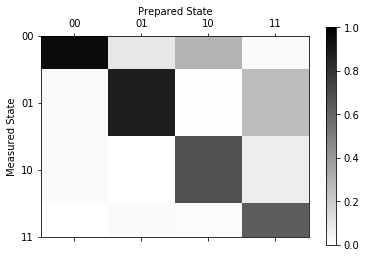

In [7]:
# Plot the calibration matrix
meas_fitter.plot_calibration()

In [8]:
# Execute the Bell state circuits
job = qiskit.execute(bell, backend = provider.get_backend('ibmqx4'), shots=1000)
results = job.result()

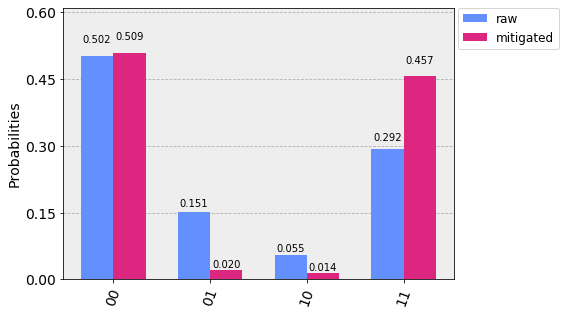

In [9]:
# Get the filter object
meas_filter = meas_fitter.filter

# Results with mitigation
mitigated_results = meas_filter.apply(results)
mitigated_counts = mitigated_results.get_counts(0)

# Plot the results with and without error mitigation
plot_histogram([results.get_counts(), mitigated_counts], legend=['raw', 'mitigated'])

# (b) Bell state with NTU-hub's 20-qubit device

In [10]:
provider = IBMQ.get_provider(hub='ibm-q-hub-ntu')

In [11]:
# Execute the calibration circuits
job = qiskit.execute(meas_calibs, backend = provider.get_backend('ibmq_poughkeepsie'), shots=1000)
cal_results = job.result()

In [12]:
# Calculate the calibration matrix
meas_fitter = CompleteMeasFitter(cal_results, state_labels, qubit_list=qubit_list, circlabel='mcal')
print(meas_fitter.cal_matrix)

[[0.973 0.068 0.061 0.005]
 [0.009 0.92  0.001 0.053]
 [0.018 0.001 0.93  0.048]
 [0.    0.011 0.008 0.894]]


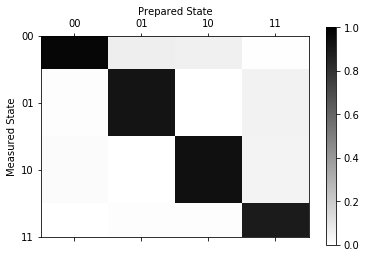

In [13]:
# Plot the calibration matrix
meas_fitter.plot_calibration()

In [14]:
# Execute the Bell state circuits
job = qiskit.execute(bell, backend = provider.get_backend('ibmq_poughkeepsie'), shots=1000)
results = job.result()

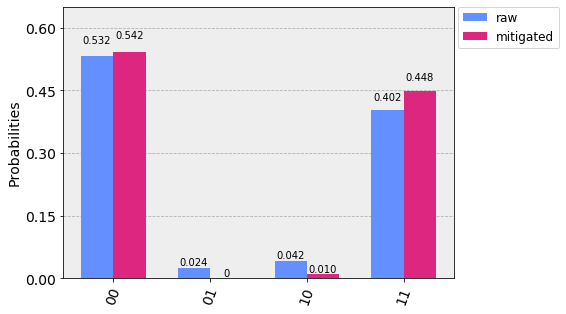

In [15]:
# Get the filter object
meas_filter = meas_fitter.filter

# Results with mitigation
mitigated_results = meas_filter.apply(results)
mitigated_counts = mitigated_results.get_counts(0)

# Plot the results with and without error mitigation
plot_histogram([results.get_counts(), mitigated_counts], legend=['raw', 'mitigated'])

# 2. Error mitigation on GHZ state on real devices

As an example, we start with the 3-qubit GHZ state on the qubits Q2,Q3,Q4:

$$ \mid GHZ \rangle = \frac{\mid{000} \rangle + \mid{111} \rangle}{\sqrt{2}}$$

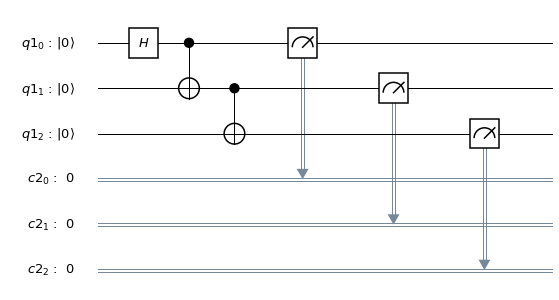

In [16]:
# Make a 3Q GHZ state
qr = QuantumRegister(3)
cr = ClassicalRegister(3)

ghz = QuantumCircuit(qr, cr)
ghz.h(qr[0])
ghz.cx(qr[0], qr[1])
ghz.cx(qr[1], qr[2])
ghz.measure(qr[0],cr[0])
ghz.measure(qr[1],cr[1])
ghz.measure(qr[2],cr[2])
ghz.draw(output='mpl')

In [17]:
# The qubits to be calibrated
qubit_list = [0,1,2]
# Generate calibration circuit
meas_calibs, state_labels = complete_meas_cal(qubit_list=qubit_list, qr=qr, circlabel='mcal')
state_labels

['000', '001', '010', '011', '100', '101', '110', '111']

# (a) GHZ with open devices (ibmqx4) 

In [18]:
provider = IBMQ.get_provider(hub='ibm-q')

In [19]:
# Execute the calibration circuits
job = qiskit.execute(meas_calibs, backend = provider.get_backend('ibmqx4'), shots=1000)
cal_results = job.result()

In [20]:
# Calculate the calibration matrix
meas_fitter = CompleteMeasFitter(cal_results, state_labels, qubit_list=qubit_list, circlabel='mcal')
print(meas_fitter.cal_matrix)

[[0.771 0.089 0.175 0.018 0.221 0.023 0.024 0.004]
 [0.023 0.691 0.007 0.168 0.003 0.183 0.    0.033]
 [0.012 0.005 0.533 0.061 0.003 0.    0.181 0.023]
 [0.    0.012 0.012 0.469 0.    0.008 0.004 0.139]
 [0.188 0.021 0.116 0.016 0.725 0.079 0.108 0.008]
 [0.003 0.176 0.004 0.101 0.033 0.691 0.004 0.097]
 [0.003 0.001 0.15  0.014 0.015 0.002 0.667 0.078]
 [0.    0.005 0.003 0.153 0.    0.014 0.012 0.618]]


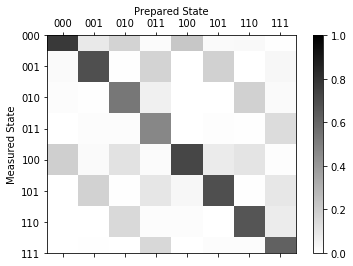

In [21]:
# Plot the calibration matrix
meas_fitter.plot_calibration()

In [22]:
# Execute the GHZ state circuits
job = qiskit.execute(ghz, backend = provider.get_backend('ibmqx4'), shots=1000)
results = job.result()

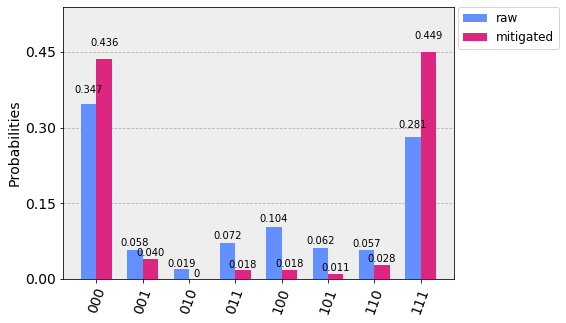

In [23]:
# Get the filter object
meas_filter = meas_fitter.filter

# Results with mitigation
mitigated_results = meas_filter.apply(results)
mitigated_counts = mitigated_results.get_counts(0)

# Plot the results with and without error mitigation
plot_histogram([results.get_counts(), mitigated_counts], legend=['raw', 'mitigated'])

# (b) GHZ with NTU-hub's 20-qubit device

In [24]:
provider = IBMQ.get_provider(hub='ibm-q-hub-ntu')

In [25]:
# Execute the calibration circuits
job = qiskit.execute(meas_calibs, backend = provider.get_backend('ibmq_poughkeepsie'), shots=1000)
cal_results = job.result()

In [26]:
# Calculate the calibration matrix
meas_fitter = CompleteMeasFitter(cal_results, state_labels, qubit_list=qubit_list, circlabel='mcal')
print(meas_fitter.cal_matrix)

[[0.971 0.081 0.043 0.003 0.066 0.002 0.002 0.002]
 [0.007 0.899 0.    0.05  0.    0.057 0.    0.003]
 [0.015 0.002 0.946 0.074 0.001 0.    0.052 0.004]
 [0.    0.011 0.006 0.864 0.    0.001 0.    0.045]
 [0.006 0.    0.    0.    0.916 0.064 0.039 0.005]
 [0.001 0.007 0.    0.    0.01  0.864 0.    0.039]
 [0.    0.    0.005 0.    0.007 0.    0.899 0.075]
 [0.    0.    0.    0.009 0.    0.012 0.008 0.827]]


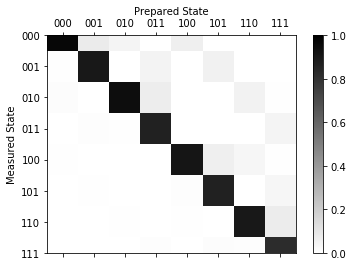

In [27]:
# Plot the calibration matrix
meas_fitter.plot_calibration()

In [28]:
# Execute the GHZ state circuits
job = qiskit.execute(ghz, backend = provider.get_backend('ibmq_poughkeepsie'), shots=1000)
results = job.result()

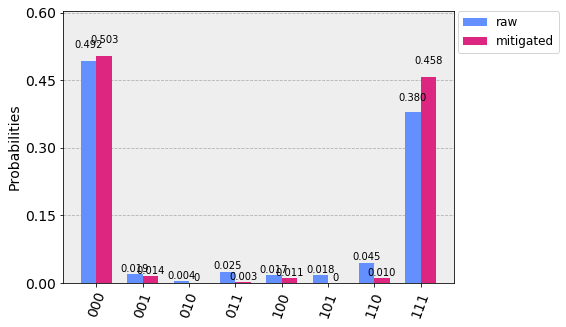

In [29]:
# Get the filter object
meas_filter = meas_fitter.filter

# Results with mitigation
mitigated_results = meas_filter.apply(results)
mitigated_counts = mitigated_results.get_counts(0)

# Plot the results with and without error mitigation
plot_histogram([results.get_counts(), mitigated_counts], legend=['raw', 'mitigated'])